# Preparation

In [ ]:
# @title Swin Transformer
import torch
import torch.nn as nn
import torch.nn.functional as F


class Residual(nn.Module):
    """Residual Block with Learnable Scaling Factor."""
    def __init__(self, *layers: nn.Module):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.gamma * self.residual(x)


class GlobalAvgPool(nn.Module):
    """Global Average Pooling Layer."""
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.mean(dim=-2)


class ShiftedWindowAttention(nn.Module):
    """Shifted Window Attention Module."""

    def __init__(self, dim: int, head_dim: int, shape: tuple, window_size: int, shift_size: int = 0):
        super().__init__()
        self.heads = dim // head_dim
        self.head_dim = head_dim
        self.scale = head_dim ** -0.5
        self.shape = shape
        self.window_size = window_size
        self.shift_size = shift_size

        # Initialize linear layers for QKV projection
        self.to_qkv = nn.Linear(dim, dim * 3)
        self.unifyheads = nn.Linear(dim, dim)

        # Positional encoding
        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * window_size - 1) ** 2))
        self.register_buffer("relative_indices", self.get_indices(window_size))

        if shift_size > 0:
            self.register_buffer("mask", self.generate_mask(shape, window_size, shift_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.to_windows(x)  # Partition into windows
        qkv = self.to_qkv(x).unflatten(-1, (3, self.heads, self.head_dim)).transpose(-2, 1)
        queries, keys, values = qkv.unbind(dim=2)

        att = queries @ keys.transpose(-2, -1) * self.scale + self.get_rel_pos_enc()  # Add relative position encoding

        if self.shift_size > 0:
            att = self.mask_attention(att)  # Apply mask if needed

        att = F.softmax(att, dim=-1)
        x = att @ values
        x = x.transpose(1, 2).contiguous().flatten(-2, -1)  # Move heads back
        x = self.unifyheads(x)
        return self.from_windows(x)  # Undo partitioning into windows

    def to_windows(self, x: torch.Tensor) -> torch.Tensor:
        """Convert input to windows."""
        x = x.unflatten(1, self.shape)
        if self.shift_size > 0:
            x = x.roll((-self.shift_size, -self.shift_size), dims=(1, 2))
        return self.split_windows(x, self.window_size)

    def from_windows(self, x: torch.Tensor) -> torch.Tensor:
        """Merge windows back into the original shape."""
        x = self.merge_windows(x, self.shape, self.window_size)
        if self.shift_size > 0:
            x = x.roll((self.shift_size, self.shift_size), dims=(1, 2))
        return x.flatten(1, 2)

    def mask_attention(self, att: torch.Tensor) -> torch.Tensor:
        """Mask attention scores."""
        num_win = self.mask.size(1)
        att = att.unflatten(0, (att.size(0) // num_win, num_win))
        att = att.masked_fill(self.mask, float('-inf'))
        return att.flatten(0, 1)

    def get_rel_pos_enc(self) -> torch.Tensor:
        """Get relative position encoding."""
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices).unflatten(-1, (self.window_size**2, self.window_size**2))
        return rel_pos_enc

    @staticmethod
    def generate_mask(shape: tuple, window_size: int, shift_size: int) -> torch.Tensor:
        """Generate attention mask."""
        region_mask = torch.full((1, *shape, 1), -1, dtype=torch.long)
        slices = [slice(0, -window_size), slice(-window_size, -shift_size), slice(-shift_size, None)]

        for idx, (i, j) in enumerate(zip(*[slices] * 2)):
            region_mask[:, i, j, :] = idx

        mask_windows = ShiftedWindowAttention.split_windows(region_mask, window_size).squeeze(-1)
        diff_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        mask = diff_mask != 0
        return mask.unsqueeze(1).unsqueeze(0)  # Add heads and batch dimension

    @staticmethod
    def split_windows(x: torch.Tensor, window_size: int) -> torch.Tensor:
        """Split the input tensor into windows."""
        n_h, n_w = x.size(1) // window_size, x.size(2) // window_size
        x = x.unflatten(1, (n_h, window_size)).unflatten(-2, (n_w, window_size))
        x = x.transpose(2, 3).flatten(0, 2).flatten(-3, -2)
        return x

    @staticmethod
    def merge_windows(x: torch.Tensor, shape: tuple, window_size: int) -> torch.Tensor:
        """Merge windows back into a single tensor."""
        n_h, n_w = shape[0] // window_size, shape[1] // window_size
        b = x.size(0) // (n_h * n_w)
        x = x.unflatten(1, (window_size, window_size)).unflatten(0, (b, n_h, n_w)).transpose(2, 3)
        return x.flatten(1, 2).flatten(-3, -2)

    @staticmethod
    def get_indices(window_size: int) -> torch.Tensor:
        """Generate relative position indices for windows."""
        x = torch.arange(window_size, dtype=torch.long)
        y1, x1, y2, x2 = torch.meshgrid(x, x, x, x, indexing='ij')
        indices = (y1 - y2 + window_size - 1) * (2 * window_size - 1) + x1 - x2 + window_size - 1
        return indices.flatten()


class FeedForward(nn.Sequential):
    """Feed Forward Network."""
    def __init__(self, dim: int, mult: int = 4):
        hidden_dim = dim * mult
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )


class TransformerBlock(nn.Sequential):
    """Transformer Block with Attention and Feed Forward Layers."""
    def __init__(self, dim: int, head_dim: int, shape: tuple, window_size: int, shift_size: int = 0, p_drop: float = 0.):
        super().__init__(
            Residual(
                nn.LayerNorm(dim),
                ShiftedWindowAttention(dim, head_dim, shape, window_size, shift_size),
                nn.Dropout(p_drop)
            ),
            Residual(
                nn.LayerNorm(dim),
                FeedForward(dim),
                nn.Dropout(p_drop)
            )
        )


class PatchMerging(nn.Module):
    """Patch Merging Layer."""
    def __init__(self, in_dim: int, out_dim: int, shape: tuple):
        super().__init__()
        self.shape = shape
        self.norm = nn.LayerNorm(4 * in_dim)
        self.reduction = nn.Linear(4 * in_dim, out_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unflatten(1, self.shape).movedim(-1, 1)
        x = F.unfold(x, kernel_size=2, stride=2).movedim(1, -1)
        x = self.norm(x)
        return self.reduction(x)


class Stage(nn.Sequential):
    """Stage of Transformer Blocks."""
    def __init__(self, num_blocks: int, in_dim: int, out_dim: int, head_dim: int, shape: tuple, window_size: int, p_drop: float = 0.):
        layers = []
        if out_dim != in_dim:
            layers.append(PatchMerging(in_dim, out_dim, shape))
            shape = (shape[0] // 2, shape[1] // 2)

        shift_size = window_size // 2
        layers.extend(TransformerBlock(out_dim, head_dim, shape, window_size, 0 if (num % 2 == 0) else shift_size,
                                    p_drop) for num in range(num_blocks))

        super().__init__(*layers)


class StageStack(nn.Sequential):
    def __init__(self, num_blocks_list: list[int], dims: list[int], head_dim: int, shape: tuple[int, int], window_size: int, p_drop: float = 0.0):
        """
        Stack of transformer stages with optional patch merging.

        Args:
            num_blocks_list (list[int]): List of number of blocks in each stage.
            dims (list[int]): List of dimensions for each stage.
            head_dim (int): Dimension of each head in the multi-head attention.
            shape (tuple[int, int]): Shape of the input.
            window_size (int): Size of the attention window.
            p_drop (float): Dropout probability.
        """
        layers = []
        in_dim = dims[0]

        for num_blocks, out_dim in zip(num_blocks_list, dims[1:]):
            # Append Stage with Patch Merging if dimensions change
            if in_dim != out_dim:
                layers.append(Stage(num_blocks, in_dim, out_dim, head_dim, shape, window_size, p_drop))
                shape = (shape[0] // 2, shape[1] // 2)
            else:
                layers.extend(Stage(num_blocks, in_dim, out_dim, head_dim, shape, window_size, p_drop) for _ in range(num_blocks))

            in_dim = out_dim

        super().__init__(*layers)

class ToPatches(nn.Module):
    def __init__(self, in_channels: int, dim: int, patch_size: int):
        """
        Converts input image into patches.

        Args:
            in_channels (int): Number of input channels.
            dim (int): Dimension of the output embedding.
            patch_size (int): Size of the patches.
        """
        super().__init__()
        self.patch_size = patch_size
        patch_dim = in_channels * patch_size ** 2
        self.proj = nn.Linear(patch_dim, dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass to convert image to patches."""
        x = F.unfold(x, kernel_size=self.patch_size, stride=self.patch_size).movedim(1, -1)
        x = self.proj(x)
        x = self.norm(x)
        return x

class AddPositionEmbedding(nn.Module):
    def __init__(self, dim: int, num_patches: int):
        """
        Adds positional embeddings to the input.

        Args:
            dim (int): Dimension of the embeddings.
            num_patches (int): Total number of patches.
        """
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.Tensor(num_patches, dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass to add positional embedding."""
        return x + self.pos_embedding

class ToEmbedding(nn.Sequential):
    def __init__(self, in_channels: int, dim: int, patch_size: int, num_patches: int, p_drop: float = 0.0):
        """Converts input image into embeddings with positional encoding."""
        super().__init__(
            ToPatches(in_channels, dim, patch_size),
            AddPositionEmbedding(dim, num_patches),
            nn.Dropout(p_drop)
        )

class Head(nn.Sequential):
    def __init__(self, dim: int, num_classes: int, p_drop: float = 0.0):
        """Classifier head for the model."""
        super().__init__(
            nn.LayerNorm(dim),
            nn.GELU(),
            GlobalAvgPool(),
            nn.Dropout(p_drop),
            nn.Linear(dim, num_classes)
        )

class SwinTransformer(nn.Sequential):
    def __init__(self, num_classes: int, image_size: int, num_blocks_list: list[int], dims: list[int], head_dim: int, patch_size: int, window_size: int,
                 in_channels: int = 3, emb_p_drop: float = 0.0, trans_p_drop: float = 0.0, head_p_drop: float = 0.0):
        """
        Swin Transformer model.

        Args:
            num_classes (int): Number of output classes.
            image_size (int): Size of the input image.
            num_blocks_list (list[int]): List of number of blocks for each stage.
            dims (list[int]): List of dimensions for each stage.
            head_dim (int): Dimension of each head in multi-head attention.
            patch_size (int): Size of the patches.
            window_size (int): Size of the attention window.
            in_channels (int): Number of input channels.
            emb_p_drop (float): Dropout probability for embedding layer.
            trans_p_drop (float): Dropout probability for transformer layers.
            head_p_drop (float): Dropout probability for head layer.
        """
        reduced_size = image_size // patch_size
        shape = (reduced_size, reduced_size)
        num_patches = shape[0] * shape[1]

        super().__init__(
            ToEmbedding(in_channels, dims[0], patch_size, num_patches, emb_p_drop),
            StageStack(num_blocks_list, dims, head_dim, shape, window_size, trans_p_drop),
            Head(dims[-1], num_classes, head_p_drop)
        )
        self.reset_parameters()

    def reset_parameters(self):
        """Reset model parameters."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.zeros_(m.bias)
            elif isinstance(m, AddPositionEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            elif isinstance(m, ShiftedWindowAttention):
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)

    def separate_parameters(self):
        """Separate model parameters into those with and without weight decay."""
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear,)
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, AddPositionEmbedding) and param_name.endswith("pos_embedding"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, ShiftedWindowAttention) and param_name.endswith("pos_enc"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # Sanity checks
        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(list(self.parameters()))

        return parameters_decay, parameters_no_decay


In [ ]:
# @title Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


In [ ]:
# @title Config & Hyperparameters
DATA_DIR='./data'

IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 64
EPOCHS = 100

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# @title Seed
import random
import numpy as np
import torch

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# @title Simple Transform
from torchvision import datasets, transforms

train_transform = transforms.Compose([
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

train_dataset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# @title Data Augmentation and Normalization
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])

aug_train_transform = transforms.Compose([
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    normalize,
])

aug_test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
    ])

aug_train_dataset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=aug_train_transform)
aug_test_dataset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=aug_test_transform)

aug_train_loader = torch.utils.data.DataLoader(aug_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
aug_test_loader = torch.utils.data.DataLoader(aug_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


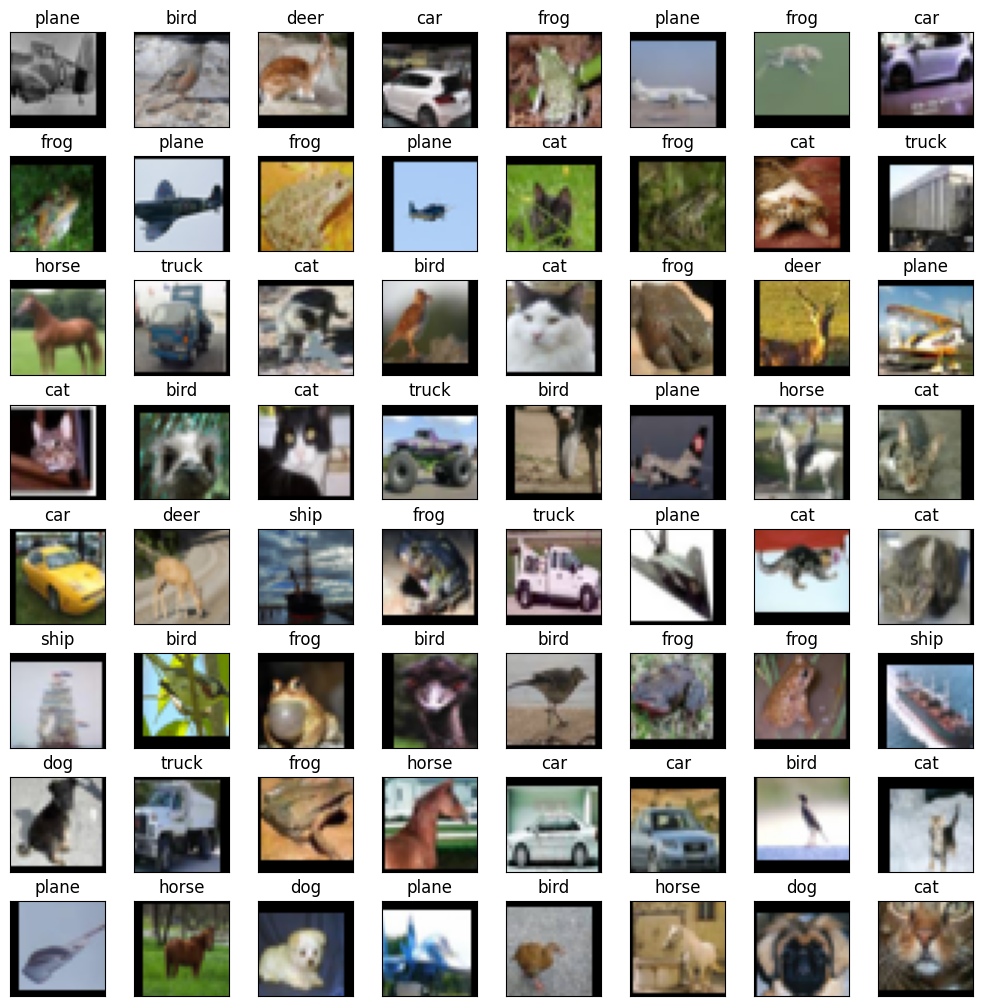

In [ ]:
# @title Train Data Show
import matplotlib.pyplot as plt

xb, yb = next(iter(train_loader))

row_num, col_num = int(BATCH_SIZE/8), 8
fig, axs = plt.subplots(row_num, col_num, figsize=(10, 10 * row_num/col_num))

for row_idx in range(row_num):
    for col_idx in range(col_num):
        ax = axs[row_idx][col_idx]
        i = col_idx * row_num + row_idx

        class_index = yb[i].item()
        class_label = classes[class_index].split(",")[0]
        img = xb[i].permute(1,2,0)
        img = np.clip(img.cpu().numpy() * 255, 0, 255).astype(np.uint8)

        ax.title.set_text(class_label)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(img)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
# @title AdamP
from torch.optim.optimizer import Optimizer, required
import math

class AdamP(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, delta=0.1, wd_ratio=0.1, nesterov=False):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay,
                        delta=delta, wd_ratio=wd_ratio, nesterov=nesterov)
        super(AdamP, self).__init__(params, defaults)

    def _channel_view(self, x):
        return x.view(x.size(0), -1)

    def _layer_view(self, x):
        return x.view(1, -1)

    def _cosine_similarity(self, x, y, eps, view_func):
        x = view_func(x)
        y = view_func(y)

        return F.cosine_similarity(x, y, dim=1, eps=eps).abs_()

    def _projection(self, p, grad, perturb, delta, wd_ratio, eps):
        wd = 1
        expand_size = [-1] + [1] * (len(p.shape) - 1)
        for view_func in [self._channel_view, self._layer_view]:

            cosine_sim = self._cosine_similarity(grad, p.data, eps, view_func)

            if cosine_sim.max() < delta / math.sqrt(view_func(p.data).size(1)):
                p_n = p.data / view_func(p.data).norm(dim=1).view(expand_size).add_(eps)
                perturb -= p_n * view_func(p_n * perturb).sum(dim=1).view(expand_size)
                wd = wd_ratio

                return perturb, wd

        return perturb, wd

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                beta1, beta2 = group['betas']
                nesterov = group['nesterov']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                # Adam
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                step_size = group['lr'] / bias_correction1

                if nesterov:
                    perturb = (beta1 * exp_avg + (1 - beta1) * grad) / denom
                else:
                    perturb = exp_avg / denom

                # Projection
                wd_ratio = 1
                if len(p.shape) > 1:
                    perturb, wd_ratio = self._projection(p, grad, perturb, group['delta'], group['wd_ratio'], group['eps'])

                # Weight decay
                if group['weight_decay'] > 0:
                    p.data.mul_(1 - group['lr'] * group['weight_decay'] * wd_ratio)

                # Step
                p.data.add_(perturb, alpha=-step_size)

        return loss

In [ ]:
# @title Optimizer
import torch.optim as optim

def get_optimizer(model, optimizer_params):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()

    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": optimizer_params.get('weight_decay', 0.0)},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]

    optimizer_type = optimizer_params.get('optimizer_type', 'adamw').lower()
    learning_rate = optimizer_params.get('learning_rate', 0.001)

    if optimizer_type == 'adamw':
        optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    elif optimizer_type == 'sgd':
        momentum = optimizer_params.get('momentum', 0.9)
        optimizer = optim.SGD(optim_groups, lr=learning_rate, momentum=momentum)
    elif optimizer_type == 'adamp':
        beta1 = optimizer_params.get('beta1', 0.9)
        beta2 = optimizer_params.get('beta2', 0.999)
        eps = optimizer_params.get('eps', 1e-8)
        weight_decay = optimizer_params.get('weight_decay', 0.0)
        # Implementing AdamP with a custom class or directly if using a library
        optimizer = AdamP(optim_groups, lr=learning_rate, betas=(beta1, beta2), eps=eps, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}. Use 'AdamW', 'SGD', or 'AdamP'.")

    return optimizer

In [ ]:
# @title Install
!pip install pytorch-ignite

In [ ]:
# @title Trainer & Evaluator
import time
import numpy as np
import torch

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite

from sklearn.metrics import classification_report

# Define a function to train the model with specified parameters
def train_model(model, train_loader, test_loader, optimizer, loss_fn, lr_scheduler, device, max_epochs=100, patience_limit=10):
    epoch_times = []
    best_val_acc = 0.0
    patience_counter = 0
    best_model_weights = None
    best_epoch = 0

    # Initialize history to track metrics
    history = defaultdict(list)

    trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
    trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step())

    ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

    val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
    evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

    @trainer.on(Events.EPOCH_STARTED)
    def start_epoch_timer(engine):
        engine.state.epoch_start_time = time.time()

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(engine):
        nonlocal best_val_acc, patience_counter, best_model_weights, best_epoch

        # Calculate epoch time
        epoch_time = time.time() - engine.state.epoch_start_time
        epoch_times.append(epoch_time)

        train_state = engine.state
        epoch = train_state.epoch
        max_epochs = train_state.max_epochs
        train_loss = train_state.metrics["loss"]

        # Log history
        history['train loss'].append(train_loss)

        evaluator.run(test_loader)
        val_metrics = evaluator.state.metrics
        val_loss = val_metrics["loss"]
        val_acc = val_metrics["accuracy"]

        # Log validation history
        history['val loss'].append(val_loss)
        history['val acc'].append(val_acc)

        print("{}/{} - train: loss {:.3f}; val: loss {:.3f}, accuracy {:.3f}, time {:.2f}s".format(
            epoch, max_epochs, train_loss, val_loss, val_acc, epoch_time))

        # Check for improvement in validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict()  # Save the model weights
            best_epoch = epoch
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter

        # Check if patience limit has been reached
        if patience_counter >= patience_limit:
            print("Early stopping: No improvement for {} epochs.".format(patience_limit))
            trainer.terminate()  # Stop training

    @trainer.on(Events.COMPLETED)
    def log_total_training_time(engine):
        total_time = sum(epoch_times)
        print(f"Total training time: {total_time:.2f}s")

        # Load the best model weights
        model.load_state_dict(best_model_weights)

        # Calculate predictions for classification report
        model.eval()  # Set model to evaluation mode
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, preds = torch.max(outputs, 1)
                all_preds.append(preds)
                all_labels.append(labels)

        # Convert lists to tensors
        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        # Print classification report
        print("Classification Report:")
        print(classification_report(all_labels, all_preds))

        # Plot training and validation loss
        fig = plt.figure()
        ax = fig.add_subplot(111)
        xs = np.arange(1, len(history['train loss']) + 1)
        ax.plot(xs, history['train loss'], '.-', label='train')
        ax.plot(xs, history['val loss'], '.-', label='val')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid()
        plt.title("Training and Validation Loss")
        plt.show()

        # Plot validation accuracy
        fig = plt.figure()
        ax = fig.add_subplot(111)
        xs = np.arange(1, len(history['val acc']) + 1)
        ax.plot(xs, history['val acc'], '-')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Validation Accuracy')
        ax.grid()
        plt.title("Validation Accuracy")
        plt.show()

    # Run the trainer
    trainer.run(train_loader, max_epochs=max_epochs)

# Define Models & Evaluate

In [ ]:
# @title Define Models
from collections import defaultdict

NUM_BLOCKS_LIST = [4, 4] # 각 스테이지에서 사용할 Transformer 블록의 개수
DIMS = [128, 128, 256] # 각 스테이지의 입력 및 출력 차원
HEAD_DIM = 32 # 멀티 헤드 어텐션에서 각 헤드의 차원
PATCH_SIZE = 2 # 입력 이미지를 나누는 패치의 크기
WINDOW_SIZE = 4 # 윈도우 기반 어텐션에서 사용하는 윈도우의 크기
EMB_P_DROP = 0. # 임베딩 레이어에서의 드롭아웃 비율
TRANS_P_DROP = 0. # Transformer 레이어에서의 드롭아웃 비율
HEAD_P_DROP = 0.3 # 멀티 헤드 어텐션의 각 헤드에서의 드롭아웃 비율

# Result Model(simple preprocessing, AdamW and OneCycle)
model = SwinTransformer(
        NUM_CLASSES, IMAGE_SIZE,
        num_blocks_list=NUM_BLOCKS_LIST,
        dims=DIMS,
        head_dim=HEAD_DIM,
        patch_size=PATCH_SIZE,
        window_size=WINDOW_SIZE,
        emb_p_drop=EMB_P_DROP,
        trans_p_drop=TRANS_P_DROP,
        head_p_drop=HEAD_P_DROP
    )

model.to(device)

SwinTransformer(
  (0): ToEmbedding(
    (0): ToPatches(
      (proj): Linear(in_features=12, out_features=128, bias=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): AddPositionEmbedding()
    (2): Dropout(p=0.0, inplace=False)
  )
  (1): StageStack(
    (0): Stage(
      (0): TransformerBlock(
        (0): Residual(
          (residual): Sequential(
            (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (1): ShiftedWindowAttention(
              (to_qkv): Linear(in_features=128, out_features=384, bias=True)
              (unifyheads): Linear(in_features=128, out_features=128, bias=True)
            )
            (2): Dropout(p=0.0, inplace=False)
          )
        )
        (1): Residual(
          (residual): Sequential(
            (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (1): FeedForward(
              (0): Linear(in_features=128, out_features=512, bias=True)
              (1): GELU(

In [ ]:
# @title Set Optimizer & Scheduler
optimizer_params_AdamW = {
    'learning_rate': 1e-3,
    'weight_decay': 1e-1,
    'optimizer_type': 'AdamW',
}

PATIENCE = 10

loss = nn.CrossEntropyLoss()
optimizer = get_optimizer(model, optimizer_params_AdamW)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=optimizer_params_AdamW['learning_rate'],
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

1/100 - train: loss 2.012; val: loss 1.976, accuracy 0.242, time 52.65s
2/100 - train: loss 1.756; val: loss 1.731, accuracy 0.365, time 51.19s
3/100 - train: loss 1.579; val: loss 1.523, accuracy 0.442, time 51.34s
4/100 - train: loss 1.432; val: loss 1.368, accuracy 0.496, time 50.69s
5/100 - train: loss 1.343; val: loss 1.304, accuracy 0.525, time 51.34s
6/100 - train: loss 1.270; val: loss 1.235, accuracy 0.552, time 51.17s
7/100 - train: loss 1.224; val: loss 1.191, accuracy 0.570, time 51.62s
8/100 - train: loss 1.204; val: loss 1.169, accuracy 0.573, time 50.92s
9/100 - train: loss 1.118; val: loss 1.069, accuracy 0.608, time 51.03s
10/100 - train: loss 1.101; val: loss 1.083, accuracy 0.607, time 50.85s
11/100 - train: loss 1.033; val: loss 0.965, accuracy 0.656, time 50.96s
12/100 - train: loss 1.016; val: loss 0.937, accuracy 0.668, time 52.01s
13/100 - train: loss 0.992; val: loss 0.988, accuracy 0.649, time 50.77s
14/100 - train: loss 0.919; val: loss 0.881, accuracy 0.689,

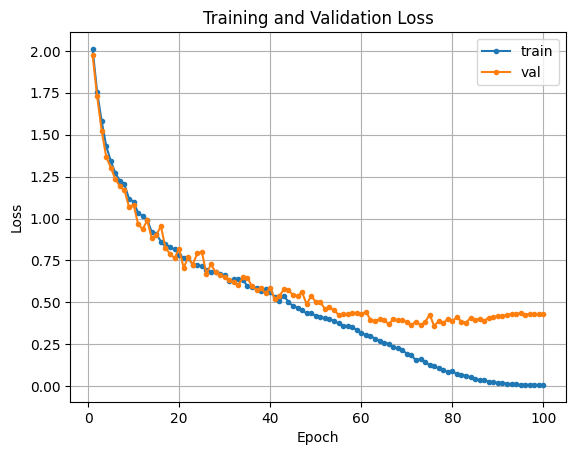

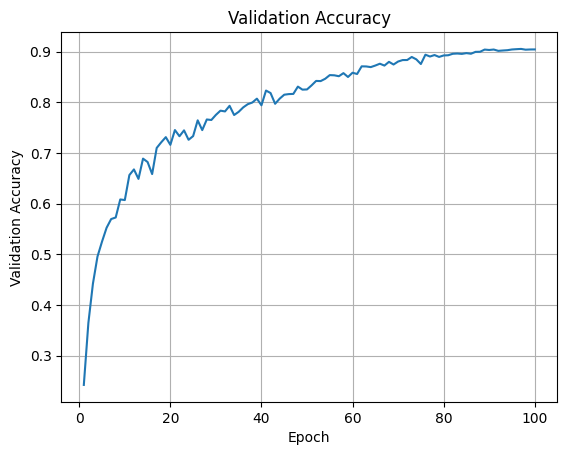

In [ ]:
# @title Training Start1
train_model(model, train_loader, test_loader, optimizer, loss, lr_scheduler, device, max_epochs=EPOCHS, patience_limit=PATIENCE)

In [ ]:
# @title Print Total Number of Parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_params}")